In [47]:
from reader import TweetsCorpusReader
from transformers import TextNormalizer, GensimVectorizer
from build_evaluate import build_and_evaluate   
from build_evaluate_svm  import build_and_evaluateSVM

from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import nltk
import os
import json
import logging
import re

log = logging.getLogger("readability.readability")
log.setLevel('WARNING')

In [48]:
# ROOT = Path('C:\\Users\\niti.mishra\\Documents\\Personal\\cyberbullying\\') # windows
ROOT = Path('/Users/peaceforlives/Documents/Projects/cyberbullying/')         # mac
CORPUS = Path.joinpath(ROOT, 'data', 'labelled_tweets', 'ab')
CORPUS_PRED = Path.joinpath(ROOT, 'data', 'filtered')
RESULTS = Path.joinpath(ROOT, 'results')

DOC_PATTERN = r'.*\.json'   

In [49]:
# corpus_pred = TweetsCorpusReader(CORPUS_PRED.__str__(), DOC_PATTERN, bullying_trace=None)
# docs = corpus_pred.docs()
# processed_predtweets = corpus_pred.process_tweet()

# normalize  = TextNormalizer()
# X_pred = list(normalize.fit_transform(processed_predtweets)) # X = [' '.join(doc) for doc in normalized_tweets]

In [50]:
target = 'bullying_trace'
#############################
PATH = target+"jupyter.pickle"

corpus = TweetsCorpusReader(CORPUS.__str__(), DOC_PATTERN, bullying_trace=target)        
# processed_tweets = corpus.process_tweet()


In [55]:
X = pd.DataFrame(corpus.strings())
X['y'] = list(corpus.fields(target))
X.head()

,0,y
0,@heyyyitsbieha bullying and helping is two dif...,yes
1,@umineko_lover @mienumirai i mean it has some ...,no
2,my take on social issues like this is that eve...,yes
3,i want to watch a group of characters ranging ...,no
4,i’d never let a fucking fetus on twitter bully...,no


In [ ]:
normalize  = TextNormalizer()
X = list(normalize.fit_transform(processed_tweets)) # X = [' '.join(doc) for doc in normalized_tweets]
y = list(corpus.fields(target))

In [28]:
import os
import time
import string
import pickle
import numpy as np
from operator import itemgetter

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts

In [29]:
def identity(words):
    return words

In [30]:
vectorizer = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, max_features=13000, 
                             ngram_range=(1,2), max_df=0.85, min_df=2)
classifier = LogisticRegressionCV
classifier = classifier(cv = 12, random_state=0,  max_iter=1000)

model = Pipeline([
            # ('preprocessor', TextNormalizer_lemmatize()),
            ('vectorizer', vectorizer),
            ('classifier', classifier),
        ])

In [31]:
# Label encode the targets
labels = LabelEncoder()
y = labels.fit_transform(y)

In [32]:
n=0.2
X_train, X_test, y_train, y_test = tts(X, y, test_size=n)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
conf_mat = np.zeros((2, 2)) 
confusion = cm(y_test, y_pred)
conf_mat += confusion

In [34]:
print(clsr(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       961
           1       0.58      0.45      0.51       613

    accuracy                           0.66      1574
   macro avg       0.64      0.62      0.62      1574
weighted avg       0.65      0.66      0.65      1574

0.5064220183486238


In [35]:
vec = model.named_steps['vectorizer']
features = vec.get_feature_names()
tfidf = vec.fit_transform(X_train + X_test)
tfidf_df = pd.DataFrame(tfidf.todense(), columns=features)
tfidf_df.head()

,$,$ $,+,+ +,+ bully,+ community,.\n\n...,. \n.,. .,. . .,...,🤷 🏽,🤷 🏾,🥰,🥴,🥴 🙄,🥺,🥺 get,🥺 💖,🥺 💜,🥺 🥺
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_idf = pd.DataFrame(vec.idf_, index=features, columns=['idf_weights'])
weights = df_idf.sort_values(by=['idf_weights'], ascending=False)
weights.to_csv('tdidfweights_'+target+'.csv', index=True)
weights

,idf_weights
eh,8.872074
deliver,8.872074
delusion,8.872074
delusional,8.872074
dem,8.872074
...,...
lunch,2.778504
gonna,2.729320
bully 🙄,2.726459
need help,2.624676


In [37]:
# highest scoring word per tweet

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    # produce the indices that would order the row by tf-idf value, reverse them and select top-n
    topn_ids = np.argsort(row)[::-1][:top_n]
#     print(topn_ids)
    top_feats = [(features[i], row[i]) for i in topn_ids]
#     print(top_feats)
    
    # convert to datafrane with the words and their corresponding score
    import pandas as pd
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    # convert sparse tfidf matrix to dense format to apply above function
    row = np.squeeze(Xtr.iloc[row_id])
#     print(row)
    return top_tfidf_feats(row, features, top_n)

In [38]:
top_feats_in_doc(tfidf_df.iloc[:len(X_train)], features, row_id=3)

,feature,tfidf
0,color,0.481335
1,end hospital,0.416123
2,think differently,0.225694
3,quality,0.224762
4,driver,0.218376
5,politically,0.218376
6,color one,0.212699
7,anyone agree,0.212699
8,camera,0.197747
9,address sister,0.172796


In [39]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr.iloc[grp_ids]
    else:
        D = Xtr

#     D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [40]:
top_mean_feats(tfidf_df, features)

,feature,tfidf
0,bring demi,0.040376
1,need help,0.020868
2,lunch,0.019591
3,gonna,0.019117
4,bully 🙄,0.018421
5,lie people,0.017963
6,moral high,0.012612
7,professional,0.012568
8,lmao yall,0.012170
9,trans,0.011673


In [41]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)

    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [42]:
import matplotlib.pyplot as plt
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

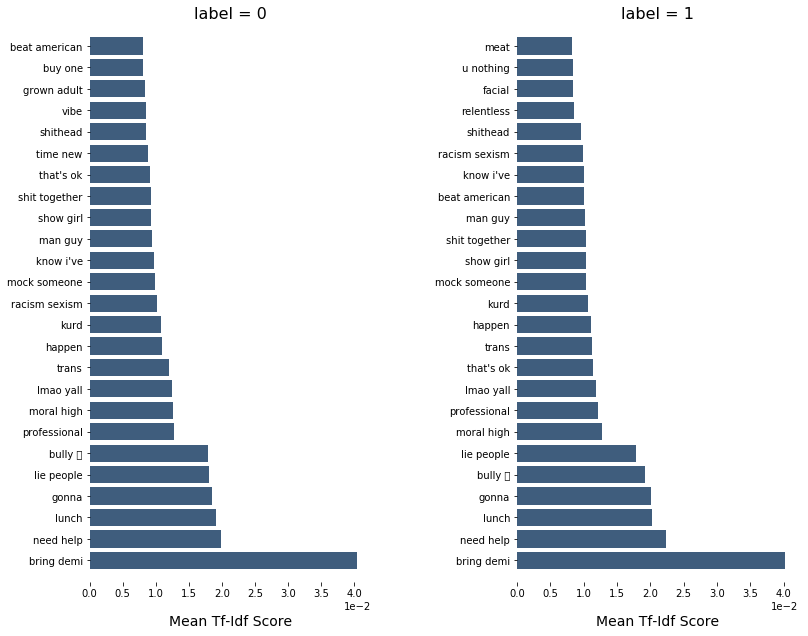

In [43]:
plot_tfidf_classfeats_h( top_feats_by_class(tfidf_df, y, features) )

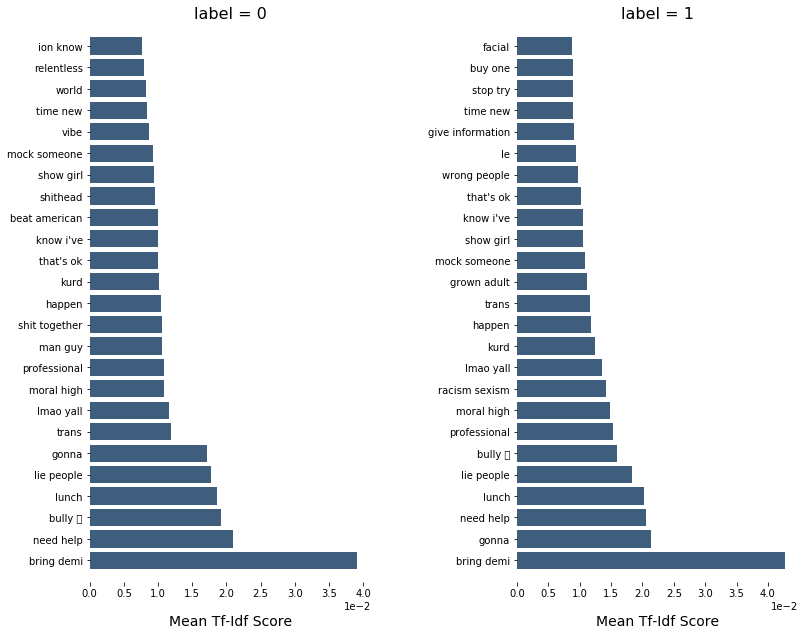

In [44]:
plot_tfidf_classfeats_h( top_feats_by_class(tfidf_df.iloc[:len(X_train)], y_train, features) )

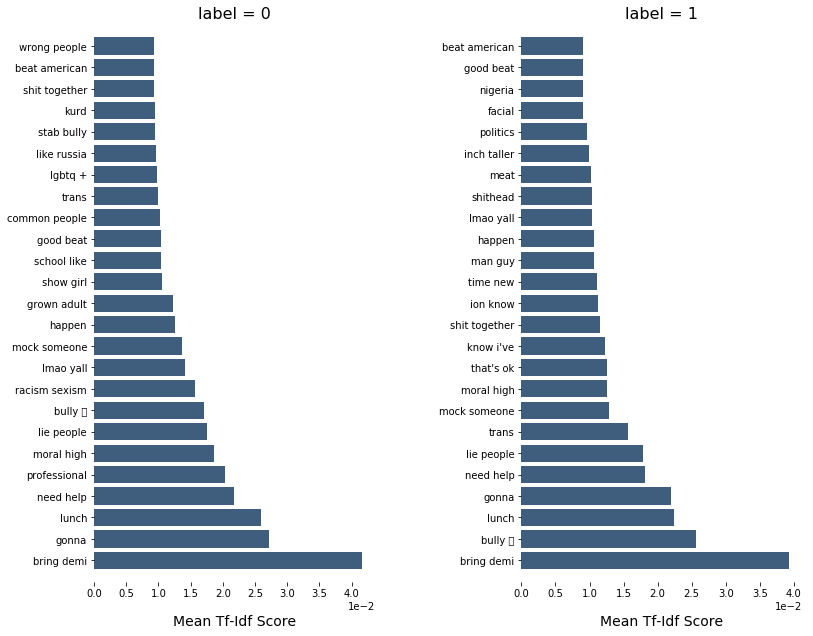

In [45]:
# Collect indices of false positive and negatives
fp_i = np.where((y_pred==1) & (y_test==0))[0]
fn_i = np.where((y_pred==0) & (y_test==1))[0]

false_testdf = tfidf_df.iloc[len(X_train):]
all_ind = list(fp_i) + list(fn_i)
plot_tfidf_classfeats_h( top_feats_by_class(false_testdf.iloc[all_ind,:], y_test[all_ind], features) )

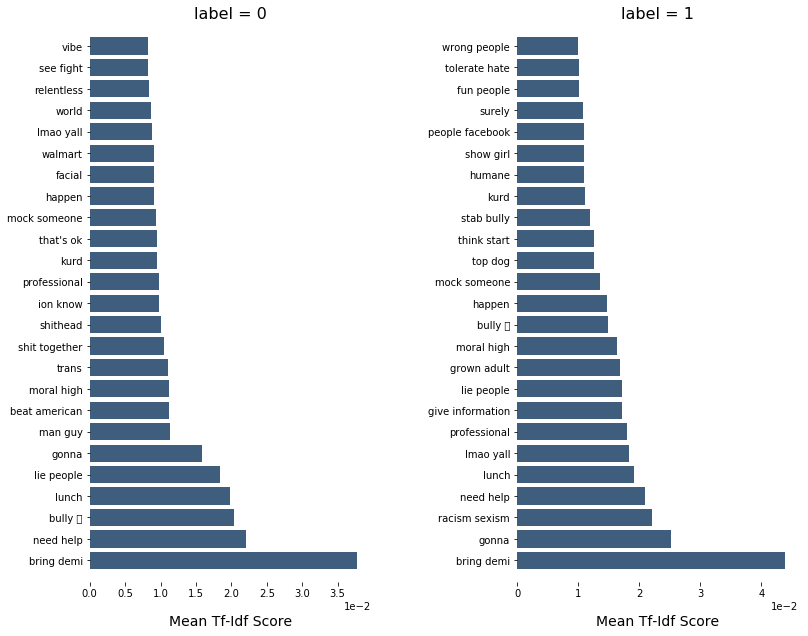

In [46]:
# Collect indices of false positive and negatives
tp_i = np.where((y_pred==0) & (y_test==0))[0]
tn_i = np.where((y_pred==1) & (y_test==1))[0]

true_testdf = tfidf_df.iloc[len(X_train):]
all_ind = list(tp_i) + list(tn_i)
plot_tfidf_classfeats_h( top_feats_by_class(true_testdf.iloc[all_ind,:], y_test[all_ind], features) )